# Exercise 8: Put all the concepts in Exercise 7 together

Skills:
* Apply all the concepts covered in Exercise 7 for a research question. Know when to use what concept.

References: 
* Exercise 7


### To Do

Narrow down the list of rail routes in CA to 3 groups. Use the SHN network to determine how much of the rail route runs near the SHN. We care only about rail routes that run entirely in CA (use stops to figure this out).

**Near** the interstate, US highway, or state highway is defined by being within a quarter mile. For this exercise, the distinction between interstate, US highway, and state highway is not important; treat any road that shows up in the dataset as "the SHN".

There are theoretically 3 groupings: 
* rail routes that are never within 0.25 miles of the SHN (>0.25
* rail routes with > 0 but less than half of its length near the SHN (0<x<0.5)
* rail routes with at least half of its length near the SHN(

Provide a table and a chart showing how many rail routes fall into each of the 3 groups by district.

Use a Markdown cell at the end to connect which geospatial concept was applied to which step of the process. The concepts that should be used are `projecting CRS`, `buffering`, `dissolve`, `clipping`, `spatial join`, `overlay`. 

---
---
## Notes
* all imported dfs are gdf 
* all with CRS 4326 (decimal degrees)
* all with active geometry col set to `geometry`
* all gdf filtered down to rail groups 0, 1 and 2
* geometry type for each gdf
    1. districts - polygon
    2. ca_highways - multi line string 
    3. routes - line string
    4. rail_routes - line string
    5. stops - point
    6. rail_stops - point
* check the plots of all the gdfs
* gdf not in CA
    1. routes (nationwide)
    2. rail routes (nationwide)
    3. stops 
    4. rail stops 
---
## Cleaning

COMPLETE project all gdf to `EPSG:2229` to get everything in feet and clip all gdf to California only

COMPLETE 1. dissolve districts map to be CA only.

    * `ca` - California polygon
        
COMPLETE 2. update `ca_highways` map to new CRS
    
COMPLETE 3. clip the other gdf to CA map. 

    * `ca_routes` - transit routes in CA
    * `ca_rail` - rail routes in CA for 0,1,2
    * `ca_stops` - transit stops in CA
    * `ca_rail_stops` - rail stops in CA for 0,1,2
     
COMPLETE 4. dissolve these ca maps to see what you get

    * `ca_routes_d`
    * `ca_rail_d`
    * `ca_stops_d`  
    * `ca_rail_stops_d`

5. check all new gdf against `gdf_check` function to ensure everything looks good
   
   
### prepare gdfs needed
1. COMPLETE buffer rail routes to 1320ft (.25miles)
    * `ca_rail`
2. dissolved all of those clipped gdf
    
        

---
---

In [1]:
import geopandas as gpd
import intake
import pandas as pd

catalog = intake.open_catalog(
    "../_shared_utils/shared_utils/shared_data_catalog.yml")

In [2]:
# Import data
districts = catalog.caltrans_districts.read()
ca_highways = catalog.state_highway_network.read()

rail_group = ['0', '1', '2']
routes = catalog.ca_transit_routes.read()
rail_routes = routes[routes.route_type.isin(rail_group)
                    ].reset_index(drop=True)

stops = catalog.ca_transit_stops.read()
rail_stops = stops[stops.route_type.isin(rail_group)
                  ].reset_index(drop=True)

---

## Geodataframe checks

---

In [3]:
#function that checks multiple aspects of a gdf

def gdf_check(gdf):(
    print(f'Dataframe type is = {type(gdf)}'),
    print(f'GDF shape is = {gdf.shape}'),
    print(f'Active geometry col name is = {gdf.geometry.name}'),
    display(gdf.head()),
    display(gdf.plot()),
    display(gdf.crs)
    )

In [ ]:
#gdf of caltrans districts
#1 row for each districts, each district is a polygon

    #gdf_check(districts)

In [ ]:
#gdf of CA highways
#each row is a segment of a route, 

    #gdf_check(ca_highways)

In [ ]:
    #rail_group

In [ ]:
#gdf of all transit routes, nation wide?

    #gdf_check(routes)

In [ ]:
#gdf of all rail routes, for the sub rail-group

    #gdf_check(rail_routes)

In [ ]:
#gdf of all transit stops

    #gdf_check(stops)

In [ ]:
#gdf of all rail stops

    #gdf_check(rail_stops)

---

## Cleaning

---

In [4]:
#setting crs and dissolving district map to one polygon
#only kept the following columns, other columns were left out.

ca = districts[['geometry', 'Shape__Area', 'Shape__Length']].to_crs('EPSG:2229').dissolve()


In [5]:
#updating initial districts gdf to new CRS
districts = districts.to_crs('EPSG:2229')



In [6]:
#update CRS for ca_highways
ca_highways = ca_highways.to_crs('EPSG:2229')


In [7]:
#CA highway gdf with 2nd, buffered geometry col.
ca_highways2 = ca_highways.assign(geom_buff = ca_highways.geometry.buffer(1320)).set_geometry('geom_buff')

In [8]:
#test to combine clipping and CRS
#TEST WORKS! apply same to other gdfs

#update CRS to feet and clip transit routes to CA. outcome is tranits routes in CA only
ca_routes = routes.to_crs('EPSG:2229').clip(ca)

In [9]:
#clipped rail routes to CA only
ca_rail = rail_routes.to_crs('EPSG:2229').clip(ca)

In [10]:
#ca_rail routes with new active geometry column buffered to .25mi

ca_rail2 = ca_rail.assign(geom_buff = ca_rail.geometry.buffer(1320)).set_geometry('geom_buff')

In [11]:
#clipped transit stops to CA only
ca_stops = stops.to_crs('EPSG:2229').clip(ca)

In [12]:
#clipped rail stops to CA only
ca_rail_stops = rail_stops.to_crs('EPSG:2229').clip(ca)

---

Checking new gdfs after clipping and new CRS

---

In [ ]:
#check CA gdf, should be a single polygon of CA
gdf_check(ca)

In [ ]:
gdf_check(districts)

In [ ]:
gdf_check(ca_highways)

In [ ]:
gdf_check(ca_highways2)

In [ ]:
gdf_check(ca_routes)

In [ ]:
gdf_check(ca_rail)

In [ ]:
gdf_check(ca_rail2)

In [ ]:
gdf_check(ca_stops)

In [ ]:
gdf_check(ca_rail_stops)

---

Dissolve and check new gdfs

---


In [ ]:
#Dissolving one by one

ca_highway_d = ca_highways.dissolve()

In [ ]:
routes_d= ca_routes.dissolve()

In [ ]:
rail_d= ca_rail.dissolve()

In [ ]:
stops_d = ca_stops.dissolve()

In [ ]:
rail_stops_d = ca_rail_stops.dissolve()

---

In [ ]:
gdf_check(ca_highway_d)

In [ ]:
gdf_check(routes_d)

In [ ]:
gdf_check(rail_d)

In [ ]:
gdf_check(stops_d)

In [ ]:
gdf_check(rail_stops_d)

In [ ]:
### try to overlay the dissolve gdfs over stuff

---
---


## Breakdown of steps

### Use the SHN network to determine how much of the rail route runs near the SHN (<.25 miles)
* need: 
    1. `ca_rail2` (buffered to .25mi)
    2. `ca_highway` 
    3. `district`

* steps:
    1. create a GDF that combines the geomtry cols of the 3 gdf
    Or make a join of 2 gdf, then overlay the 3rd?
        * can i join 2 routes/line together, then overlay on district?
    
    
### (list of) rail routes that are never within 0.25 miles of the SHN
    * need:
        1. rail route map
        2. highway map
        need to buffer highway map to 1320ft.
        use overlay `systemic difference` to get get rai routes THAT DO NOT touch the buffered highway?!
        

### (list of) rail routes with > 0 but less than half of its length near the SHN
    1. buffered rail route to < half_len
    

### (list of) rail routes with at least half of its length near the SHN
    1. buffered rail route to >= half_len

---
---

Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (145, 11)
Active geometry col name is = geom_buff


,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry,geom_buff
167,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805EB_190513,89,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6467811.689 1844958.751, 6467905.8...","POLYGON ((6467900.569 1846279.119, 6468010.695..."
168,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805WB_190513,88,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6491361.499 1839175.379, 6491362.1...","POLYGON ((6471162.297 1846334.759, 6471168.277..."
161,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802EB_190513,91,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6447247.135 1884754.987, 6447751.8...","POLYGON ((6448933.329 1884330.766, 6449168.390..."
162,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802WB_190513,91,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,"LINESTRING (6491361.510 1839175.378, 6491362.2...","POLYGON ((6452950.740 1871989.509, 6452949.298..."
147,recC5CT95EufmQCXr,Santa Clara Valley Transportation Authority,BlueS,0,"Due to construction, portions of Light Rail re...",110754,2,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,https://api.511.org/transit/datafeeds?api_key=...,"LINESTRING (5426631.150 3064619.004, 5427824.4...","POLYGON ((5427478.397 3055391.367, 5427457.482..."


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

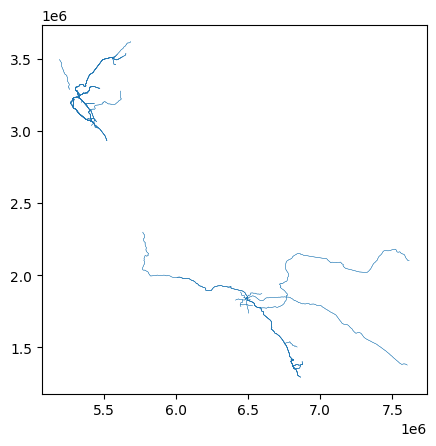

In [17]:
#(list of) rail routes that are never within 0.25 miles of the SHN

#get CA rail routes - 'ca_rail2' (with buffered col)
#get CA highway map - `ca_highways2' (with buffered col)
#add new geom column to highway map that buffers to 1320ft
#use overlay to find rail routes that do not touch buffered geom col

gdf_check(ca_rail2)


Dataframe type is = <class 'geopandas.geodataframe.GeoDataFrame'>
GDF shape is = (1052, 7)
Active geometry col name is = geom_buff


,Route,County,District,RouteType,Direction,geometry,geom_buff
0,1,LA,7,State,NB,"MULTILINESTRING ((6518147.781 1746024.206, 651...","MULTIPOLYGON (((6418422.544 1822537.036, 64183..."
1,1,LA,7,State,SB,"MULTILINESTRING ((6441469.111 1802436.519, 644...","MULTIPOLYGON (((6419949.608 1824653.780, 64202..."
2,1,MEN,1,State,NB,"MULTILINESTRING ((4921021.829 3983216.471, 492...","POLYGON ((4911745.763 3829424.582, 4911745.763..."
3,1,MEN,1,State,SB,"MULTILINESTRING ((4925456.388 3944268.826, 492...","POLYGON ((4911745.763 3829424.582, 4911745.763..."
4,1,MON,5,State,NB,"MULTILINESTRING ((5458132.055 2852112.660, 545...","POLYGON ((5402587.103 2750654.347, 5402573.418..."


<AxesSubplot:>

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

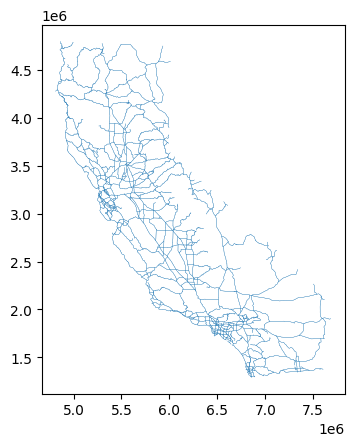

In [16]:
gdf_check(ca_highways2)

In [21]:
#test overlay of `ca_rail2` and `ca_highways2`, Result: a map of rail routes that are NOT touching a highway

#testing different orders for overlays and how=

highway_rail = gpd.overlay(ca_highways2, ca_rail2, how='symmetric_difference', keep_geom_type=True)
rail_highway = gpd.overlay(ca_rail2, ca_highways2, how='symmetric_difference', keep_geom_type=True)

In [26]:
def test(x,y):
    display(x.head()),
    display(y.head()),
    display(x.plot(color='red')),
    display(y.plot(color='green'))
    return

,Route,County,District,RouteType,Direction,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,geometry
0,1.0,LA,7.0,State,NB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((6506105.811 1747298.179, 65061..."
1,1.0,LA,7.0,State,SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((6506104.501 1747258.116, 65061..."
2,1.0,MEN,1.0,State,NB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4911745.763 3829424.582, 4911745.763..."
3,1.0,MEN,1.0,State,SB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4911745.763 3829424.582, 4911745.763..."
4,1.0,MON,5.0,State,NB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((5402587.103 2750654.347, 5402573.418..."


,org_id,agency,route_id,route_type,route_name,shape_id,n_trips,base64_url,uri,Route,County,District,RouteType,Direction,geometry
0,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805EB_190513,89.0,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((6492880.929 1839795.418, 64928..."
1,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,805,1,Metro D-Line,805WB_190513,88.0,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((6492791.718 1839620.040, 64927..."
2,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802EB_190513,91.0,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((6492696.214 1839448.449, 64926..."
3,recPnGkwdpnr8jmHB,Los Angeles County Metropolitan Transportation...,802,1,Metro B-Line,802WB_190513,91.0,aHR0cHM6Ly9naXRsYWIuY29tL0xBQ01UQS9ndGZzX3JhaW...,https://gitlab.com/LACMTA/gtfs_rail/raw/master...,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((6492687.934 1839384.134, 64926..."
4,recC5CT95EufmQCXr,Santa Clara Valley Transportation Authority,BlueS,0,"Due to construction, portions of Light Rail re...",110754,2.0,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZW...,https://api.511.org/transit/datafeeds?api_key=...,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((5458902.176 3020696.057, 54588..."


<AxesSubplot:>

<AxesSubplot:>

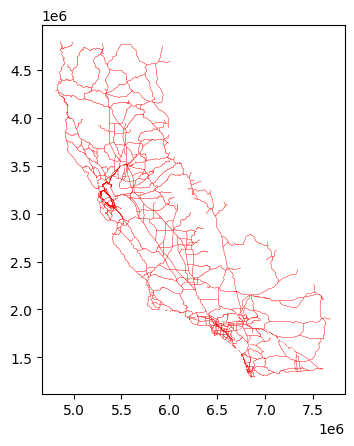

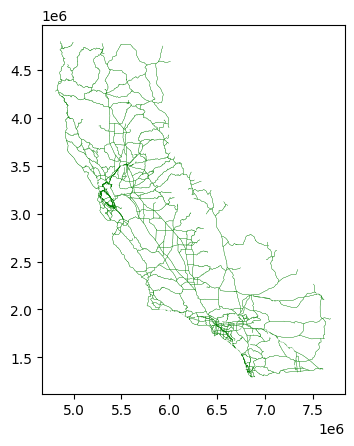

In [27]:
test(highway_rail, rail_highway)

In [ ]:
#from Amanda's ex. she:
#1. joined rail routes and rail stops (inner, intersects)
#2. overlayed highway(disolved) and rail routes join

---
hall of shame (test stuff)

---

In [ ]:
#what happens if you overlay points on polygon? which datasets are point and which are polygons?
#ca_rail_stops = points, ca_rail2 (bufferd rail routes) = polygon

#test = gpd.overlay(ca_rail_stops, ca_rail2, how='union', keep_geom_type=False)
#test.plot()

In [ ]:
#test of points on line
#ca_rail_stops on ca_rail

#dont think sjoin gives me what i imagine (example of sjoin is more closer to clipping)

#test of overlay
#how ='intersection`: from gdf1, 
#how ='difference': from gdf1 remove the part that is gf2

#does ca, ca_rail2, 'difference' show something different because both gdf have polygon geom type?

#what about if both gdf are lines?
#when its ca_highways,ca_rail2, difference: start to see gaps missing from highways

#join1 = gpd.overlay(ca_stops, ca_highways2, how = 'intersection', keep_geom_type = True)

#gdf_check(join1)

In [ ]:
#Test of sjoins
#sjoin ca_rail and ca_highways
#doesnt look like it works as we are plotting lines on lines

#join1 = gpd.sjoin(ca_rail2, ca_highways, how = 'inner', predicate = 'intersects')

#when sjoin is ca_rail2,ca_highways, inner, intersects, get 3000 rows and map looks like rail routes
#when sjoin is ca_rail2,ca_highways, left, intersects; similar results
#when sjoin is ca_rail2,ca_highways, inner, within; no data and no map
#when sjoin is ca_rail2,ca_highways, inner, contains; 68 rows, looks to be northern california
#when sjoin is ca_rail2,ca_highways, inner, touches; no data no map
#when sjoin is ca_rail2,ca_highways, inner, overlaps; no data no map

#gdf_check(join1)

In [ ]:
#test of same sjoin, but swapping order. not working, says geometry col not set and cant plot

# when ca_highway, ca_ril2, inner, intersects: 

#join2 = gpd.sjoin(ca_highways, ca_rail2.set_geometry('geom_buff'), how = 'inner', predicate = 'intersects')
#join2.head()


In [ ]:
#ca_rail is rail routes in CA buffered to 1320ft(.25miles)
#gdf_check(ca_rail)

In [ ]:
#ca_highways.plot()

In [ ]:
# add new col for length and half-legth of rail route from ca_rail
# may need this later to update buffer
#ca_rail = ca_rail.assign(length = ca_rail.geometry.length)
#ca_rail.head()

In [ ]:
#Test of overlay districts and ca_rail_buffer 

#overlay = gpd.overlay(
#    districts2229,
#    ca_rail_buffer.set_geometry('g_buffer'),
#    how = 'difference',
#    keep_geom_type=True
#)


In [ ]:
#districts2229

In [ ]:
#ca_rail_buffer.head(2)

In [ ]:
#got something when i overlay districts and rail routes!

#inspect what happens to the geometry column after overlaying. are there any duplicate rows? if so, why.
#are the routes the same after the overlay?
#remember to use length, and % of something. 
# 
#display(overlay)
#display(overlay.geometry.name)
#overlay.plot()

In [ ]:
#import matplotlib.pyplot as plt



In [ ]:
#try dissolving highways2999.
#overlay changes geometry values.
#try overlay to get length of rail route that interects
#try to find difference of overlayed geomety from SHN

#highways2229

In [ ]:
#found this via youtube tutorial.
#maps the highways and rail routes over distrcts

#fig, ax = plt.subplots(figsize = (10,8))
#highways2229.plot(ax = ax, edgecolor = 'black')
#ca_rail_buffer.plot(ax= ax, edgecolor = 'white')
#districts2229.plot(ax = ax)